<a id='Import_Libraries_and_load_dataset'></a>
## **1. Import Libraries and Load Dateset** ##

In [1]:
# Import necessary libraries
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_style("darkgrid", {
    "axes.facecolor": "0.7",
    "axes.edgecolor": ".1",
    "grid.color": ".1",
    "grid.linestyle": ":",})
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import shap
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load the dataset
df = pd.read_csv("data/final_df.csv")

b:\anaconda3\envs\exoplanet_detection_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='Initial_Exploration'></a>
## **2. Initial Exploration** ##

In [2]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\n", df.info())
print("\n", df.describe())
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes.value_counts())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values[missing_values > 0])

# Check the target variable distribution
print("\nTarget Variable Distribution:")
print(df['koi_disposition'].value_counts())

Dataset Shape: (8036, 50)

First 5 Rows:
       kepid kepoi_name   kepler_name         ra        dec  koi_kepmag  \
0  11904151  K00072.01   Kepler-10 b  285.67938  50.241299      10.961   
1  11904151  K00072.02   Kepler-10 c  285.67938  50.241299      10.961   
2   6521045  K00041.02  Kepler-100 b  291.38599  41.990269      11.197   
3   6521045  K00041.01  Kepler-100 c  291.38599  41.990269      11.197   
4   6521045  K00041.03  Kepler-100 d  291.38599  41.990269      11.197   

  koi_disposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  ...  pl_insol  \
0       CONFIRMED      0.000              1              0  ...  3741.780   
1       CONFIRMED      0.982              0              0  ...    18.300   
2       CONFIRMED      1.000              0              0  ...   478.214   
3       CONFIRMED      1.000              0              0  ...   208.657   
4       CONFIRMED      1.000              0              0  ...    53.981   

   pl_imppar  pl_trandep  st_teff  st_rad  st_mass

<a id='Data_Cleaning'></a>
## **3. Data Cleaning** ##

In [3]:
# Drop unnecessary and redundant columns (IDs, metadata, leakage-prone features)
columns_to_drop = [
    # Identifiers
    "kepid", "kepoi_name", "kepler_name", 'ra', 'dec',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    'koi_time0bk',  "sky_coord.ra", "sky_coord.dec", "pl_name", "hostname",
    
    # Metadata about discovery (not physical features)
    "disc_year", "discoverymethod", "tran_flag",
    "disc_facility", "disc_telescope", "disc_instrument",
    
    # Leakage-prone columns
    "koi_score",  # Kepler pipeline classifier output
    "pl_orbper", "pl_rade", "pl_masse", "pl_dens",
    "pl_insol", "pl_imppar", "pl_trandep",

    # Merge artifacts
    "_merge",
]

# Drop the unnecessary columns
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

# Also drop columns with high percentage of missing values
missing_percentage = df_clean.isnull().sum() / len(df_clean) * 100
high_missing_columns = missing_percentage[missing_percentage > 30].index.tolist()
df_clean = df_clean.drop(columns=high_missing_columns, errors='ignore')

# Handle remaining missing values
# For numerical columns, fill with median
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].apply(lambda x: x.fillna(x.median()))

# For categorical columns, fill with mode
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')

print("Dropped Columns: ", columns_to_drop + high_missing_columns)
print("\nDataframe shape after cleaning: ", df_clean.shape)
print("\n", df_clean.describe())
print("\n", df_clean)
print("\nData Types:\n", df_clean.dtypes.value_counts())

Dropped Columns:  ['kepid', 'kepoi_name', 'kepler_name', 'ra', 'dec', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_time0bk', 'sky_coord.ra', 'sky_coord.dec', 'pl_name', 'hostname', 'disc_year', 'discoverymethod', 'tran_flag', 'disc_facility', 'disc_telescope', 'disc_instrument', 'koi_score', 'pl_orbper', 'pl_rade', 'pl_masse', 'pl_dens', 'pl_insol', 'pl_imppar', 'pl_trandep', '_merge', 'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_age', 'st_dens']

Dataframe shape after cleaning:  (8036, 15)

         koi_kepmag   koi_period  koi_duration      koi_depth  koi_model_snr  \
count  8036.000000  8036.000000   8036.000000    8036.000000    8036.000000   
mean     14.314303    36.997573      5.375843   26490.420744     291.063352   
std       1.371521    86.526662      6.362784   84851.749259     839.432595   
min       6.966000     0.259820      0.052000       0.000000       0.000000   
25%      13.502750     2.404379      2.407573     163.075000      14.400000   

<a id='Filtering_and_Encoding'></a>
## **4. Filtering and Encoding** ##

In [ ]:
# IQR filter because of the extreme scales often involved in astronomy several values are extremely high, skewing visualiations.
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.10)
    Q3 = df_clean[col].quantile(0.90)
    IQR = Q3 - Q1
    df_filtered = df_clean[(df_clean[col] >= (Q1 - 1.5 * IQR)) & (df_clean[col] <= (Q3 + 1.5 * IQR))]
    
df_filtered_encoded = df_filtered.copy()

df_filtered_encoded['koi_disposition'] = df_filtered_encoded['koi_disposition'].map({'CANDIDATE':2, 'CONFIRMED':1, 'FALSE POSITIVE':0})

<a id='Exploratory_Data_Analysis'></a>
## **5. Exploratory Data Analysis** ##

### Correlation Heatmap

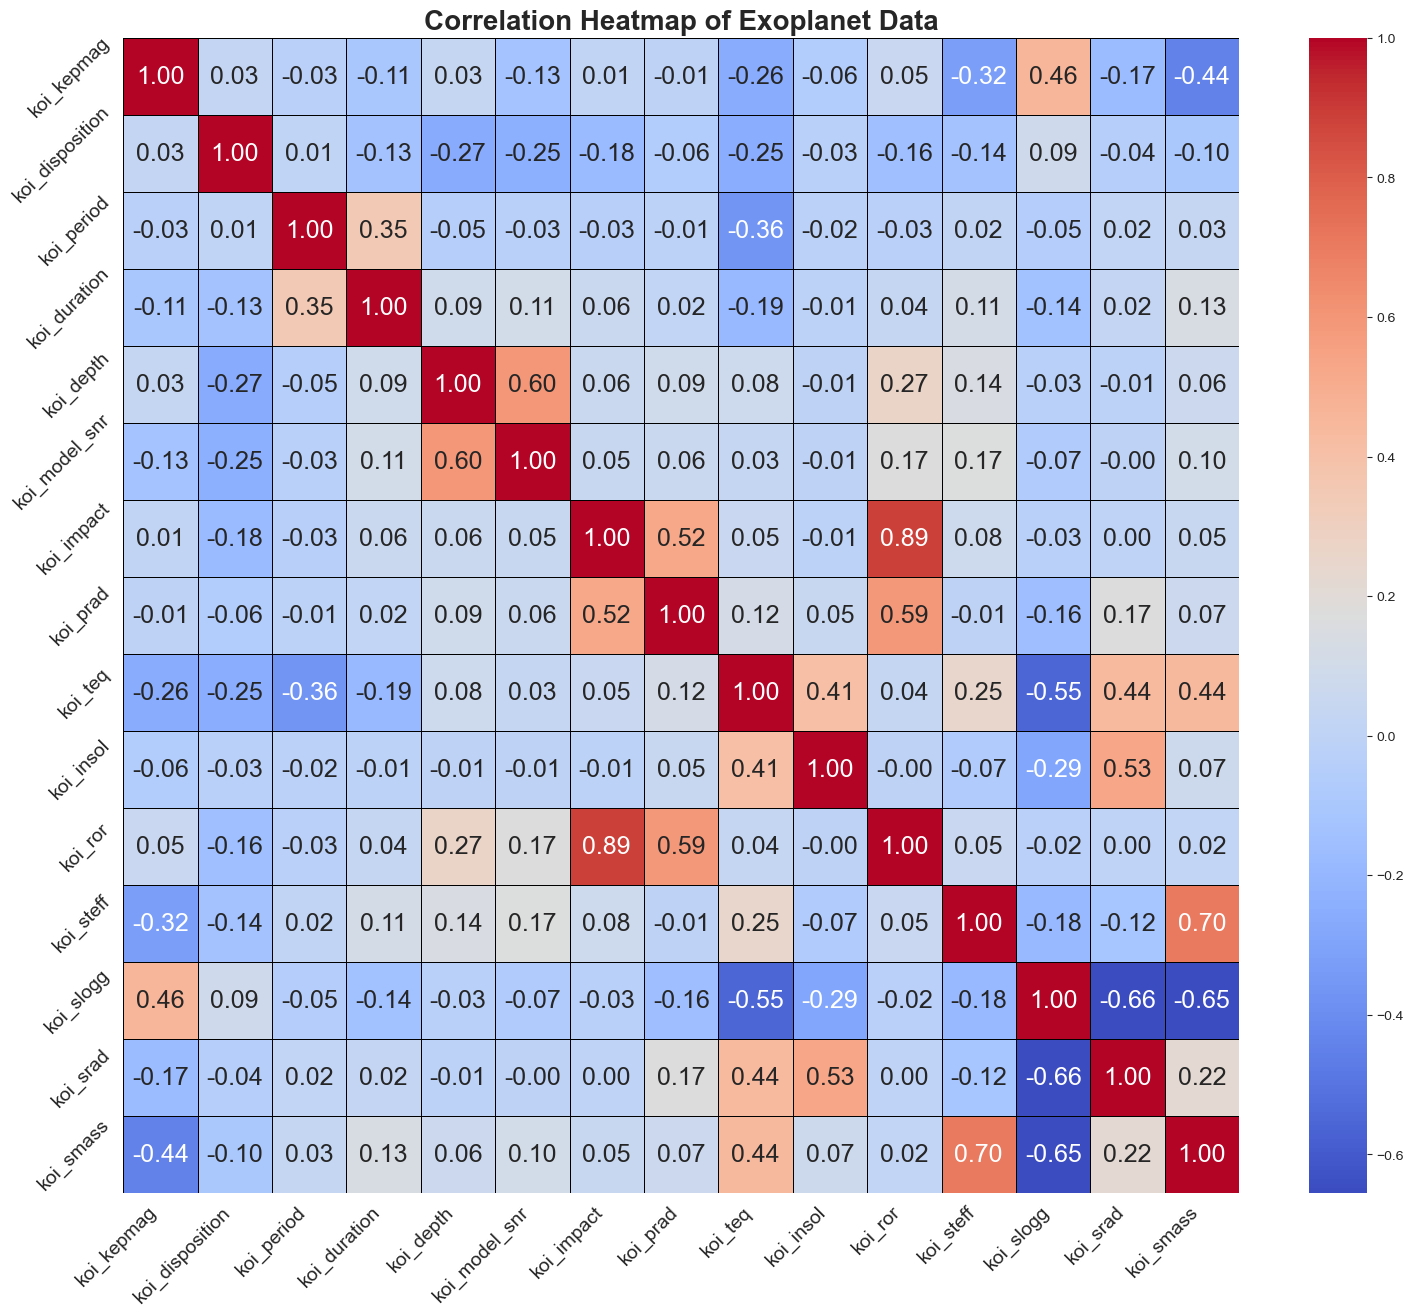

In [5]:
plt.figure(figsize=(18, 15))
correlation_matrix = df_filtered_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, annot_kws={'fontsize':18}, cmap='coolwarm', fmt=".2f", linecolor="Black", linewidths=0.5, edgecolor='Black')
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14, rotation=45, ha='right')
plt.title('Correlation Heatmap of Exoplanet Data', fontsize=20, fontweight='bold')
#plt.savefig('correlation_heatmap.png')
plt.show()

### Distribution of Target Variable

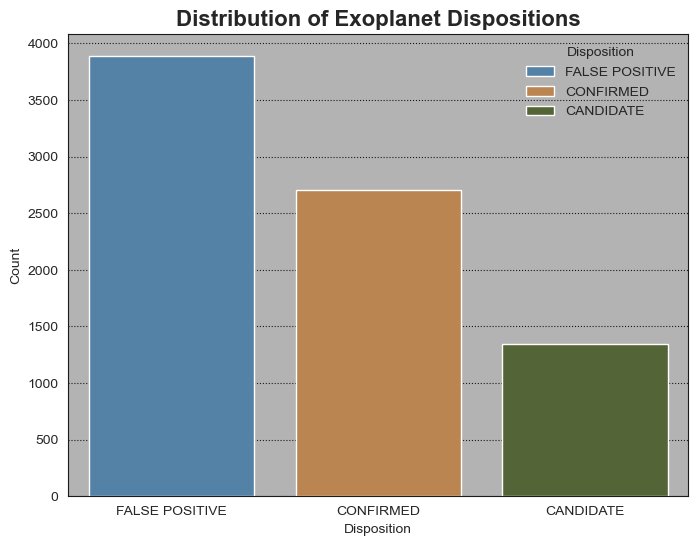

In [6]:
df_filtered_copy = df_filtered.copy()
df_filtered_copy.sort_values(by='koi_disposition', ascending=False, inplace=True)

custom_palette = {'FALSE POSITIVE': mcolors.to_rgba('steelblue'),
                  'CONFIRMED': mcolors.to_rgba('peru'),
                  'CANDIDATE': mcolors.to_rgba('darkolivegreen')}

plt.figure(figsize=(8, 6))
sns.countplot(data=df_filtered_copy, x='koi_disposition', hue='koi_disposition', palette=custom_palette)
plt.title('Distribution of Exoplanet Dispositions', fontsize=16, fontweight='bold')
plt.legend(title='Disposition',  frameon=False, labels=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE'])
plt.xlabel('Disposition')
plt.ylabel('Count')
#plt.savefig('disposition_distribution.png')
plt.show()

### Feature Distributions

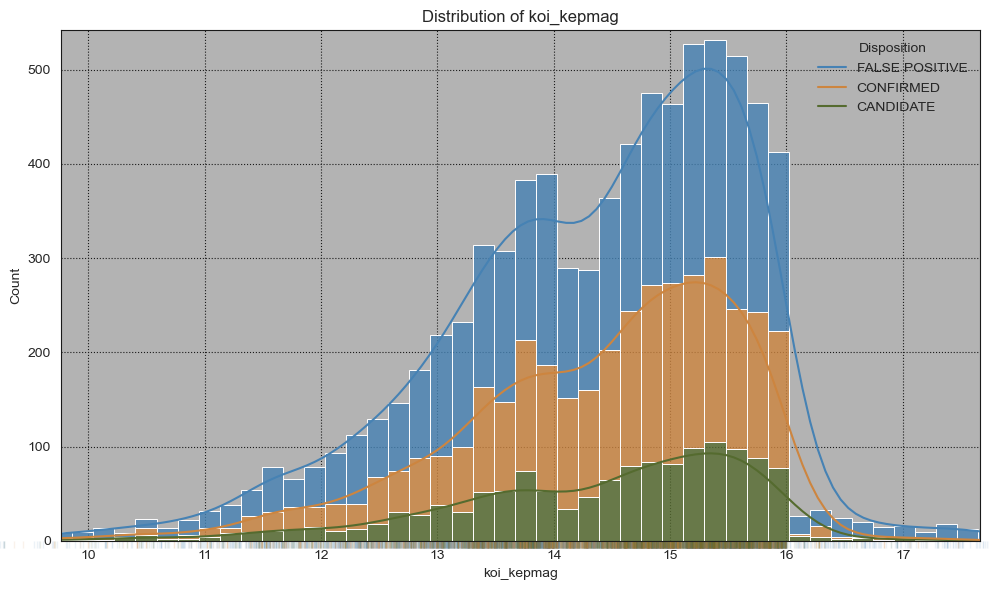

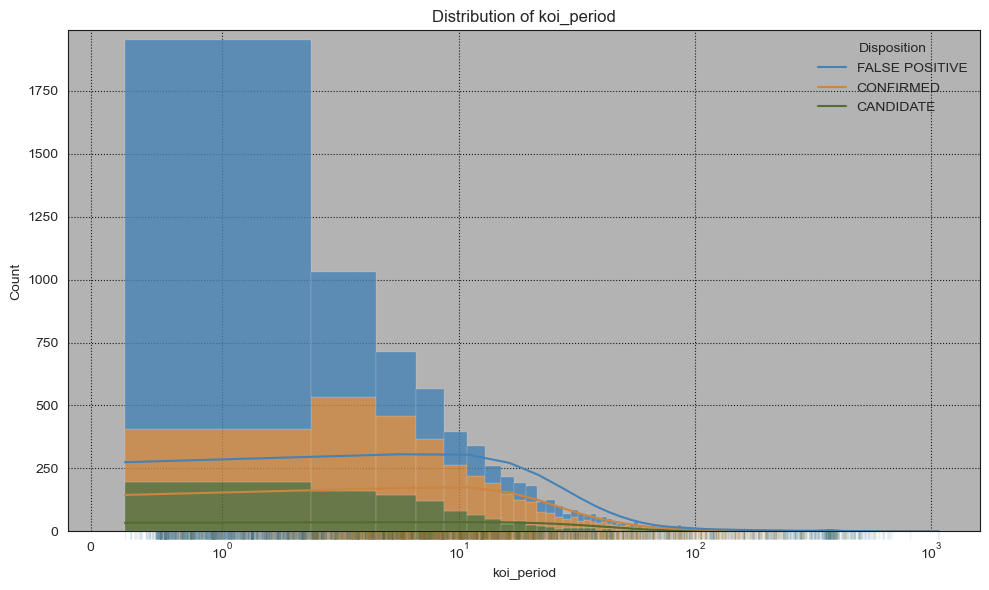

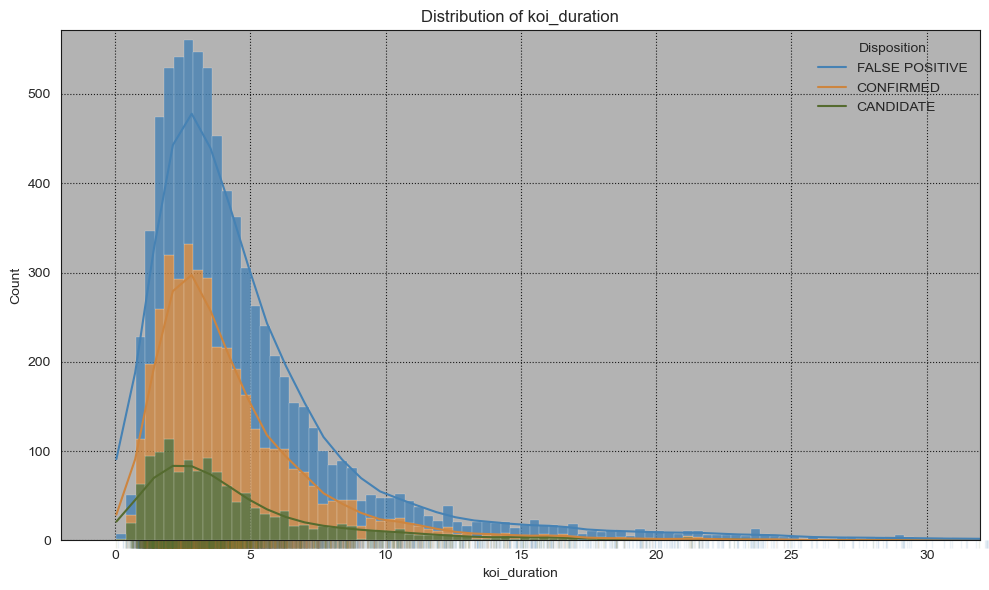

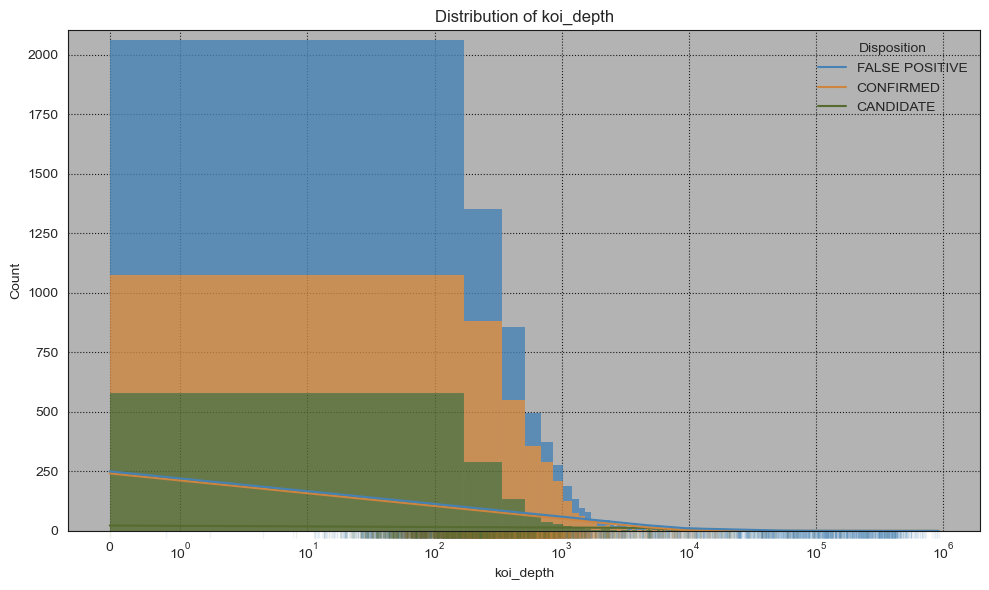

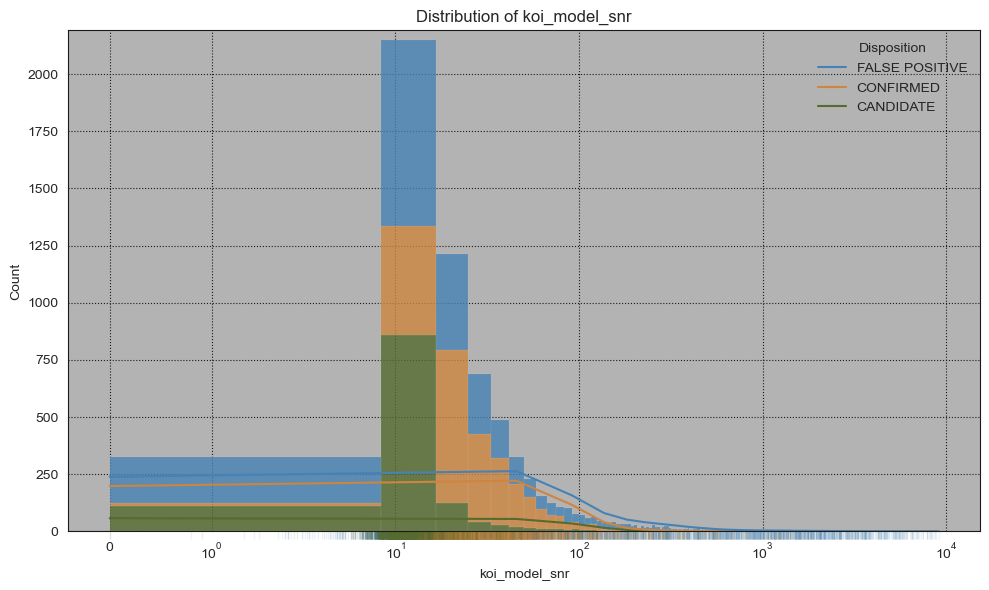

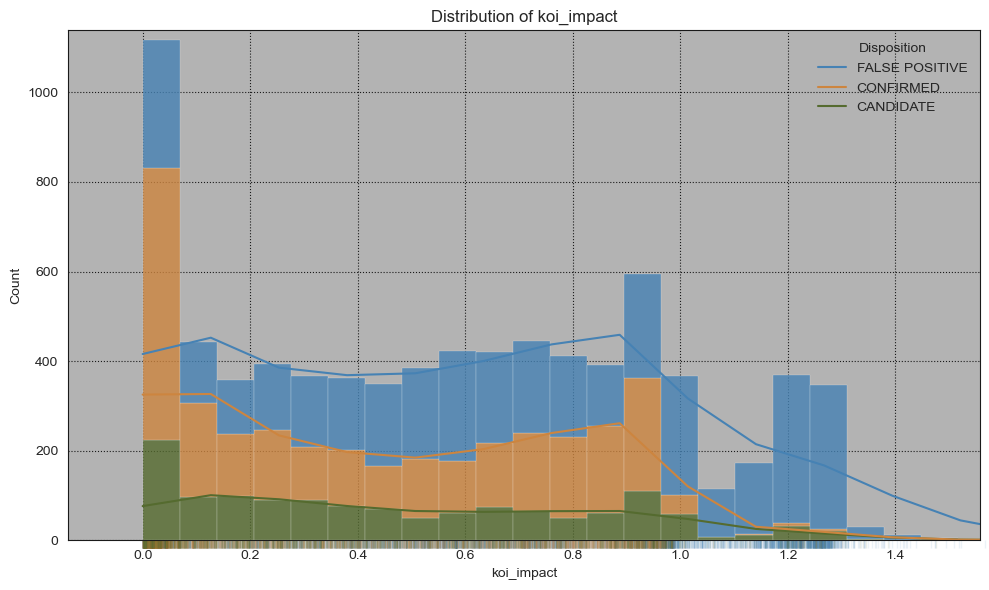

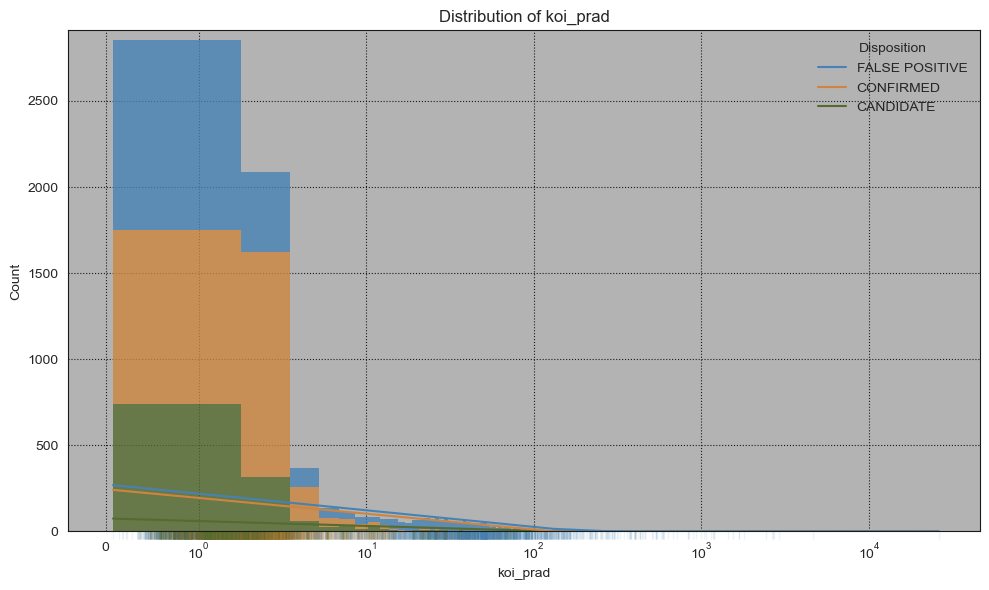

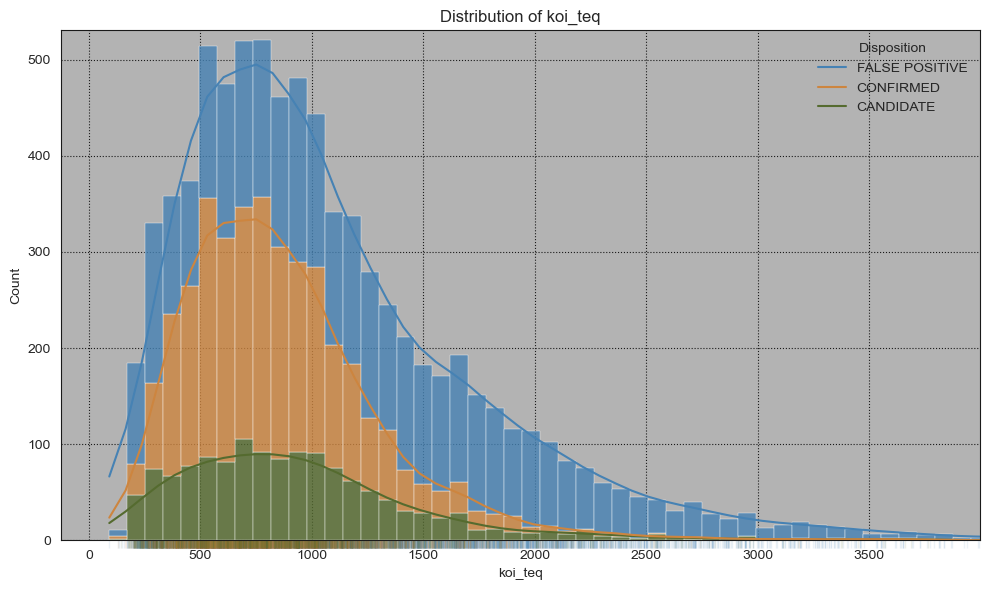

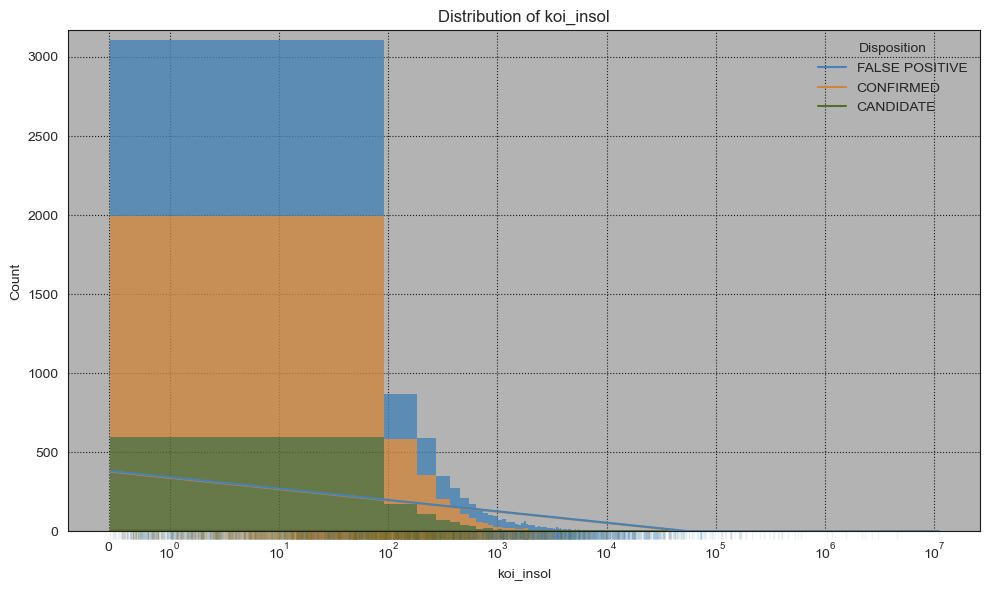

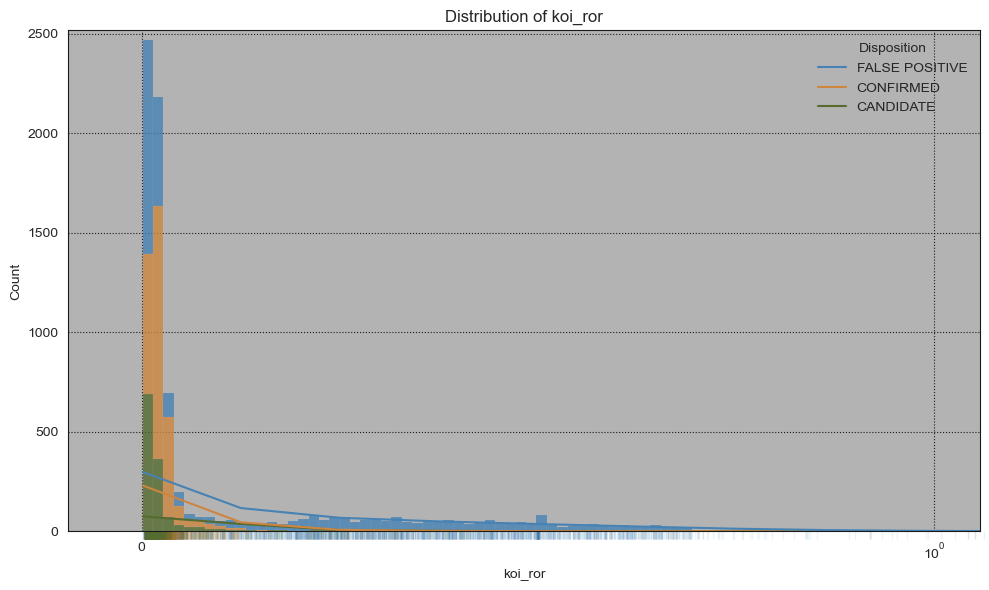

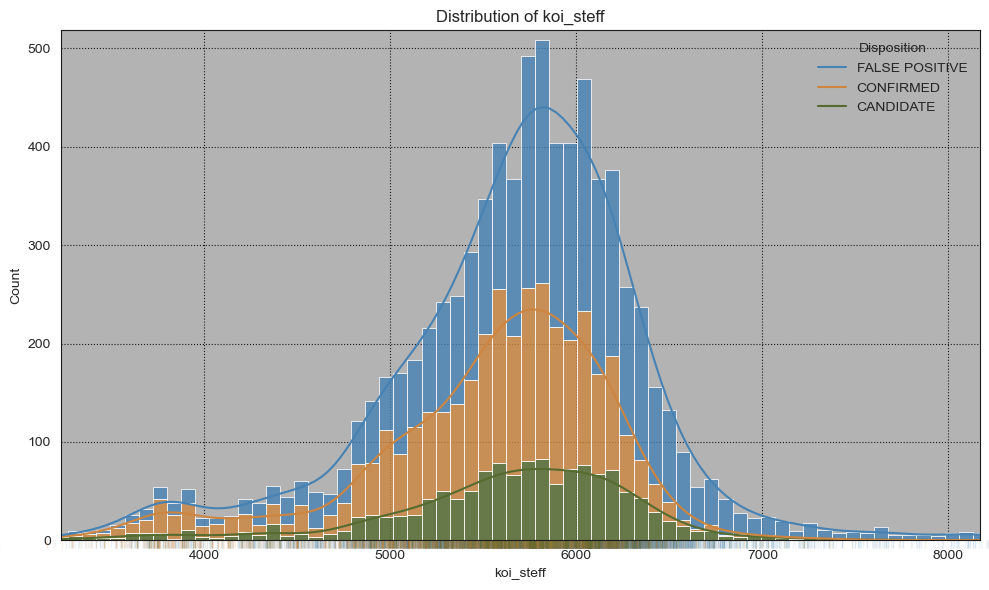

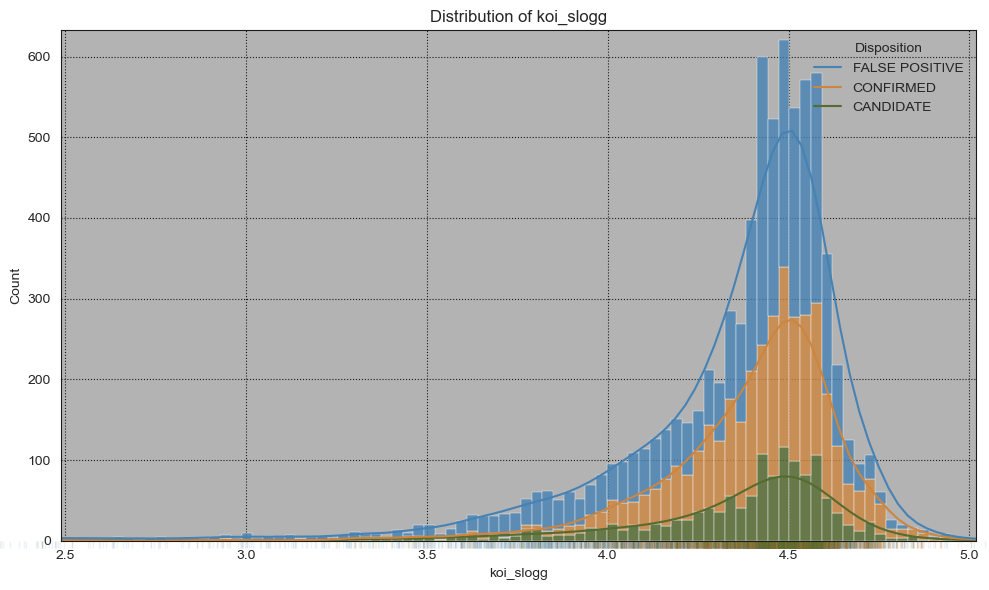

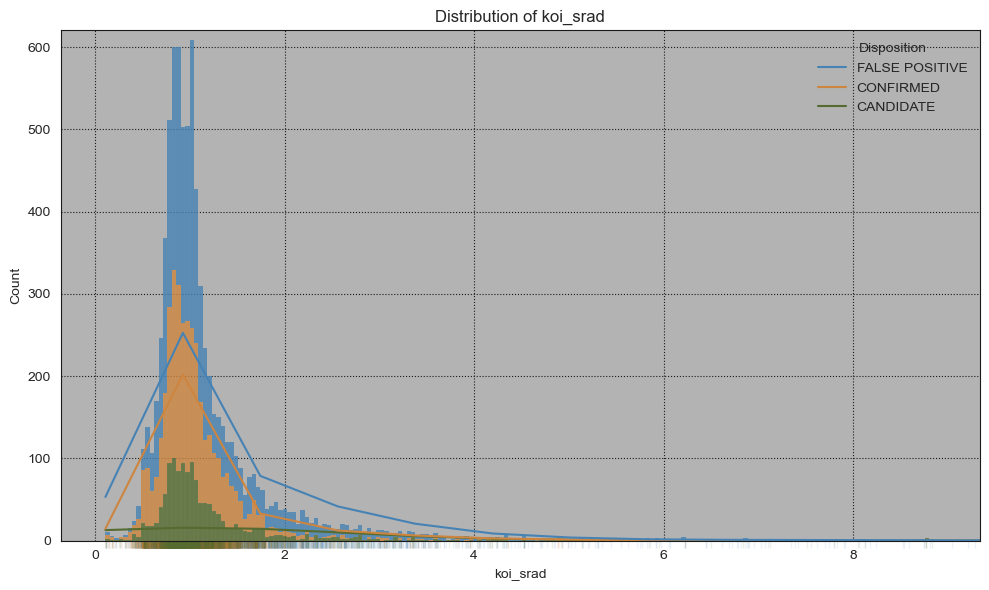

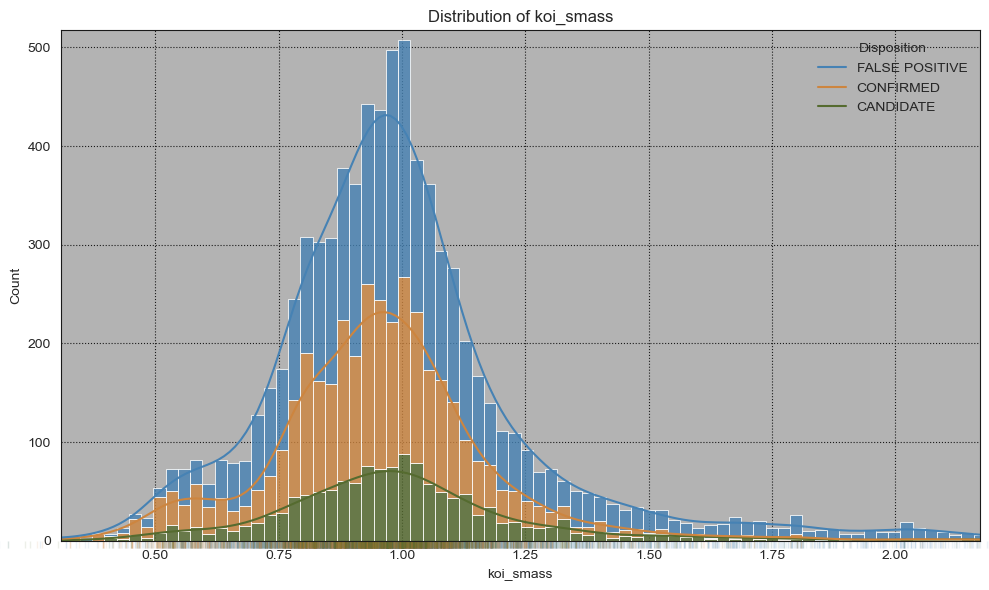

In [7]:
for feature in df_filtered.copy().drop(columns=['koi_disposition']).columns:
    
    plt.figure(figsize=(10, 6))
    
    # histogram with KDE
    if feature in ['koi_period','koi_depth', 'koi_model_snr', 'koi_prad', 'koi_insol']:
        ax = sns.histplot(data=df_filtered_copy, x=feature, hue='koi_disposition', kde=True, multiple='stack',
                      palette=custom_palette, alpha=0.8)
        ax.set_xscale('symlog', linthresh=1, linscale=0.5)
        ax.set_autoscale_on(True)
    elif feature == 'koi_ror':
        ax = sns.histplot(data=df_filtered_copy, x=feature, hue='koi_disposition', kde=True, multiple='stack',
                      palette=custom_palette, alpha=0.8)
        ax.set_xscale('symlog', linthresh=1, linscale=0.5)
        low, high = df_filtered_copy[feature].quantile([0.01, 0.99])
        margin = (high - low) * 0.1
        ax.set_xlim(low - margin, high + margin)
    else:
        ax = sns.histplot(data=df_filtered_copy, x=feature, hue='koi_disposition', kde=True, multiple='stack',
                      palette=custom_palette, alpha=0.8)
        low, high = df_filtered_copy[feature].quantile([0.01, 0.99])
        margin = (high - low) * 0.1
        ax.set_xlim(low - margin, high + margin)
    
    sns.rugplot(data=df_filtered_copy, x=feature, hue='koi_disposition', palette=custom_palette, 
                height=-.015, clip_on=False, lw=0.1, alpha=0.1, ax=ax)
    
    sns.move_legend(ax, loc='upper right', title='Disposition', frameon=False)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

### Pair Plot for selected features

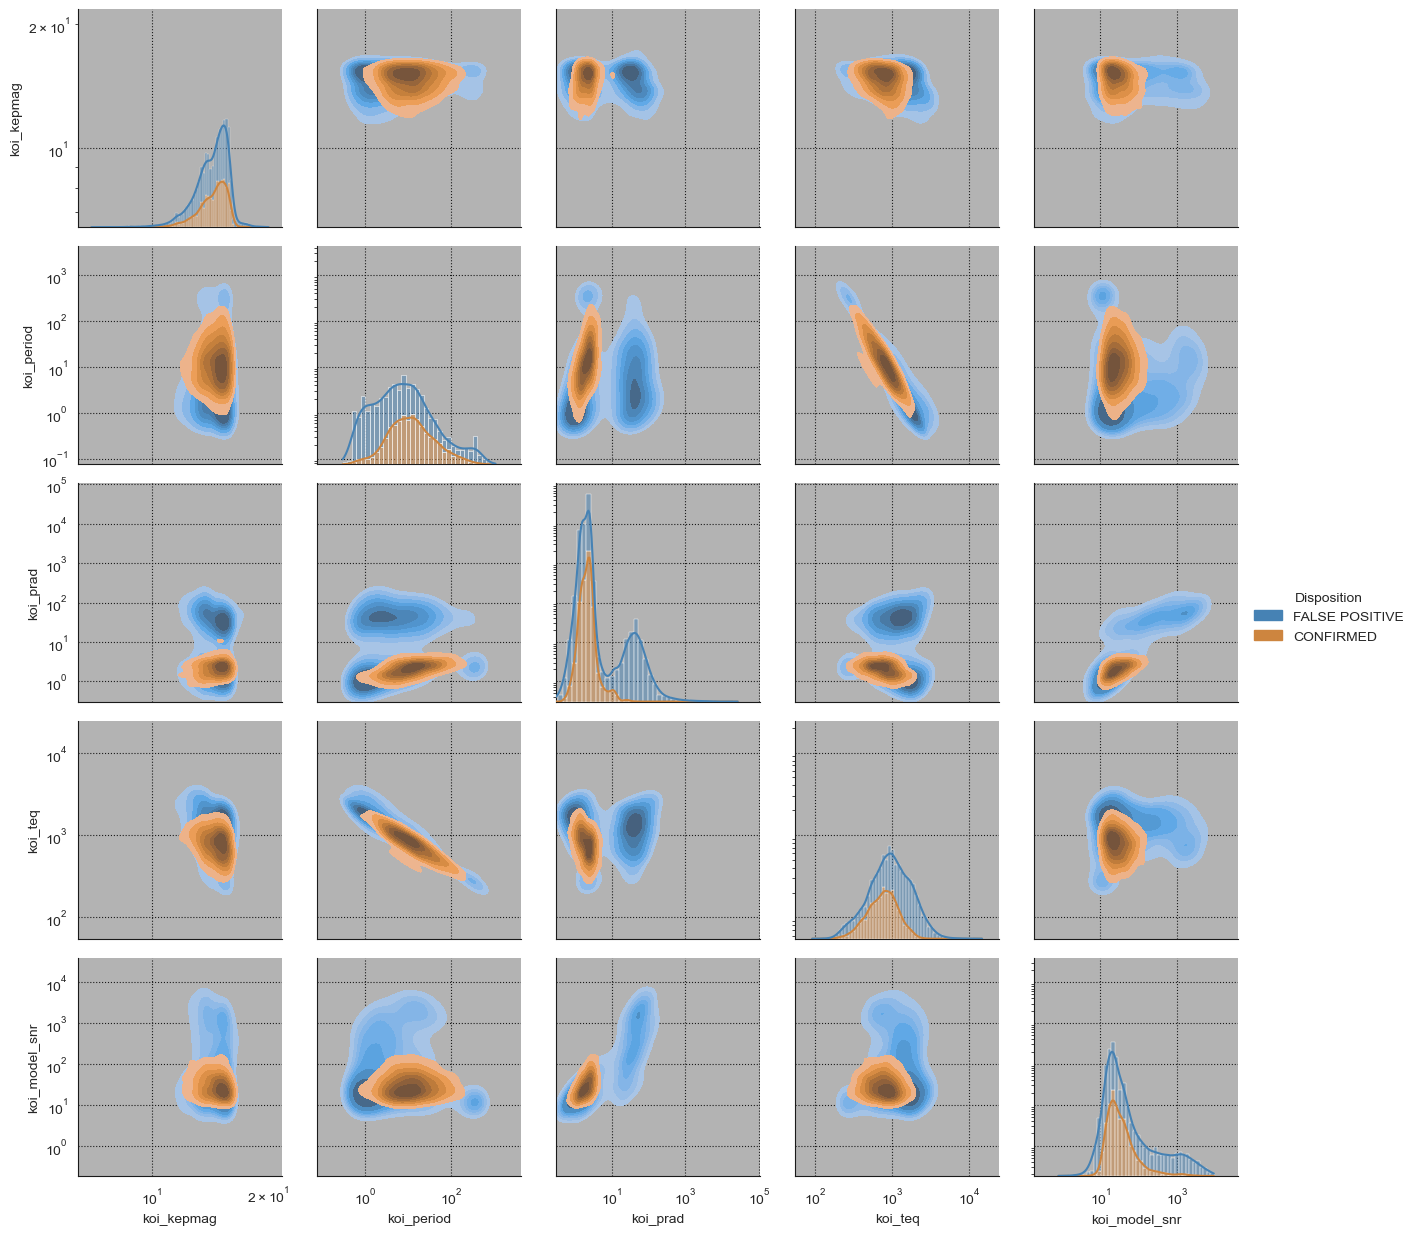

In [8]:
selected_features = ['koi_kepmag', 'koi_period', 'koi_prad', 'koi_teq', 'koi_model_snr', 'koi_disposition']
numerical_cols = ['koi_period', 'koi_prad', 'koi_teq', 'koi_model_snr']
df_filtered_copy = df_filtered_copy[df_filtered_copy['koi_disposition'] != 'CANDIDATE']

df_filtered_positive = df_filtered_copy[(df_filtered_copy[numerical_cols] > 0).all(axis=1)].copy()

pairplt=sns.PairGrid(df_filtered_positive[selected_features], hue='koi_disposition', palette=custom_palette)

pairplt.map_diag(sns.histplot, kde=True, multiple='stack', log_scale=(True, False))

pairplt.map_offdiag(sns.kdeplot, fill=True, log_scale=(False, True), common_norm=False, levels=8, thresh=0.15)

pairplt.add_legend(title='Disposition', loc='center right', frameon=False)
#plt.savefig('pair_plot.png')
plt.show()

<a id='Preprocessing'></a>
## **6. Preprocessing** ##

In [ ]:
# As potential exoplanets(CANDIDATE) are just unknowns we will focus on just confirmed exoplanets and 'false positives', i.e. not an exoplanet. The model can then be used to predict the final status of the potential exoplanets
df_filtered_encoded_copy = df_filtered_encoded[df_filtered_encoded['koi_disposition'] != 2]

# Define features (X) and target (y)
X = df_filtered_encoded_copy.drop(columns=['koi_disposition'])
y = df_filtered_encoded_copy['koi_disposition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X_Train shape: ", X_train.shape, " X_Test shape: ", X_test.shape,
      "y_Train shape: ", y_train.shape, " y_Test shape: ", y_test.shape)

numeric_cols = X.select_dtypes(include=[np.number]).columns
# NOTE: here we have only one categorical column 'koi_disposition' which is our target
#categorical_cols = X.select_dtypes(include=['object']).columns

numeric_cache = joblib.Memory(location='cache/numeric', verbose=0)
#categorical_cache = joblib.Memory(location='cache/categorical', verbose=0)
pipe_cache = joblib.Memory(location='cache/pipe', verbose=0)

# Preprocessors
# For numerical columns, impute with median
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("scaler", RobustScaler()),
    ("empty", "passthrough")
], memory=numeric_cache)

# For categorical columns, impute with mode
'''categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
], memory=categorical_cache)'''

preprocess = ColumnTransformer(
    n_jobs=-1,
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        #("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

pipe = Pipeline(steps=[("pre", preprocess),
                       ("select", SelectKBest(score_func=f_classif, k=40)), 
                       ("model", "passthrough")
                    ],
                memory=pipe_cache,
                verbose=True)

X_Train shape:  (5276, 14)  X_Test shape:  (1319, 14) y_Train shape:  (5276,)  y_Test shape:  (1319,)


<a id='7. Hyperparameter Optimization, Prediction and Evaluation'></a>
## **7. Hyperparameter Optimization, Prediction and Evaluation** ##

#### Define models and Search spaces for optimization

In [10]:
models = {
    "Gaussion Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=42, class_weight='balanced'),
    "k-Nearest Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest Classifier": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42, verbose=1),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM Classifier": LGBMClassifier(verbose=-1, random_state=42, scale_pos_weight=3886/2709),
    "XGBoost Classifier": XGBClassifier(random_state=42, scale_pos_weight=3886/2709),
    "Stacking Classifier": StackingClassifier(
                            estimators=('lr', LogisticRegression()), 
                            final_estimator=LogisticRegression(max_iter=300, random_state=42, class_weight='balanced'),
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            verbose=1, n_jobs=-1),
}

# Define hyperparameter search spaces
param_spaces = {
    "Gaussion Naive Bayes": {
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__var_smoothing': Real(1e-18, 1, prior='log-uniform'),
    },
    "Logistic Regression": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__C': Real(1e-6, 1e6, prior='log-uniform'),
        'model__penalty': Categorical(['l2']),
        'model__solver': Categorical(['newton-cg', 'lbfgs', 'liblinear', 'saga'])
        },
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__C': Real(1e-6, 1e6, prior='log-uniform'),
        'model__penalty': Categorical([None]),
        'model__solver': Categorical(['newton-cg', 'lbfgs', 'saga'])
        },
    ],
    "k-Nearest Neighbors Classifier": {
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__n_neighbors': Integer(3, 15),
        'model__weights': Categorical(['uniform', 'distance']),
        'model__p': Integer(1, 2),
    },
    "Decision Tree Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_split': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__criterion': Categorical(['gini', 'entropy'])
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_split': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__criterion': Categorical(['gini', 'entropy'])
        },
    ],
    "Random Forest Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__n_estimators': Integer(50, 300),
        'model__max_depth': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__min_samples_split': Integer(2, 20),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
        'model__criterion': Categorical(['gini', 'entropy'])
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__n_estimators': Integer(50, 300),
        'model__max_depth': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__min_samples_split': Integer(2, 20),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
        'model__criterion': Categorical(['gini', 'entropy'])
        },
    ],
    "Gradient Boosting Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__n_estimators': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__max_depth': Integer(3, 10),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
        'model__criterion': Categorical(['friedman_mse', 'squared_error']),
        'model__loss': Categorical(['log_loss', 'exponential'])
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__n_estimators': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__max_depth': Integer(3, 10),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
        'model__criterion': Categorical(['friedman_mse', 'squared_error']),
        'model__loss': Categorical(['log_loss', 'exponential'])
        },
    ],
    "CatBoost Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__iterations': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__depth': Integer(3, 10),
        'model__l2_leaf_reg': Real(1e-8, 100, prior='log-uniform'),
        'model__bagging_temperature': Real(0, 1, prior='uniform'),
        'model__random_strength': Real(1e-8, 10, prior='log-uniform'),
        'model__min_data_in_leaf': Integer(1, 100),
        'model__border_count': Integer(32, 255),
        'model__auto_class_weights': Categorical(['None', 'Balanced', 'SqrtBalanced']),
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__iterations': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__depth': Integer(3, 10),
        'model__l2_leaf_reg': Real(1e-8, 100, prior='log-uniform'),
        'model__bagging_temperature': Real(0, 1, prior='uniform'),
        'model__random_strength': Real(1e-8, 10, prior='log-uniform'),
        'model__min_data_in_leaf': Integer(1, 100),
        'model__border_count': Integer(32, 255),
        'model__auto_class_weights': Categorical(['None', 'Balanced', 'SqrtBalanced']),
        },
    ],
    "LightGBM Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__n_estimators': Integer(50, 300),
        'model__num_leaves': Integer(8, 128),
        'model__max_depth': Integer(3, 15),
        'model__reg_alpha': Real(1e-8, 100, prior='log-uniform'),
        'model__reg_lambda': Real(1e-8, 100, prior='log-uniform'),
        'model__min_child_samples': Integer(5, 100),
        'model__max_bin': Integer(50, 255),
        'model__min_child_weight': Real(1e-3, 10, prior='log-uniform'),
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__n_estimators': Integer(50, 300),
        'model__num_leaves': Integer(8, 128),
        'model__max_depth': Integer(3, 15),
        'model__reg_alpha': Real(1e-8, 100, prior='log-uniform'),
        'model__reg_lambda': Real(1e-8, 100, prior='log-uniform'),
        'model__min_child_samples': Integer(5, 100),
        'model__max_bin': Integer(50, 255),
        'model__min_child_weight': Real(1e-3, 10, prior='log-uniform'),
        },
    ],
    "XGBoost Classifier": [
       {'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select__k': Categorical([20, 60, 100, "all"]),
        'model__n_estimators': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__max_depth': Integer(3, 10),
        'model__gamma': Real(0, 1, prior='uniform'),
        'model__reg_alpha': Real(1e-8, 100, prior='log-uniform'),
        'model__reg_lambda': Real(1e-8, 100, prior='log-uniform'),
        'model__min_child_weight': Real(1e-3, 10, prior='log-uniform'),
        'model__max_delta_step': Real(0, 10, prior='uniform'),
        'model__colsample_bynode': Real(0.5, 1.0, prior='uniform'),
        },
       {'pre__num__poly': Categorical(["passthrough"]),
        'pre__num__scaler': Categorical([StandardScaler(), RobustScaler(),"passthrough"]),
        'select': Categorical(["passthrough"]),
        'model__n_estimators': Integer(50, 300),
        'model__learning_rate': Real(0.01, 0.2, prior='uniform'),
        'model__max_depth': Integer(3, 10),
        'model__gamma': Real(0, 1, prior='uniform'),
        'model__reg_alpha': Real(1e-8, 100, prior='log-uniform'),
        'model__reg_lambda': Real(1e-8, 100, prior='log-uniform'),
        'model__min_child_weight': Real(1e-3, 10, prior='log-uniform'),
        'model__max_delta_step': Real(0, 10, prior='uniform'),
        'model__colsample_bynode': Real(0.5, 1.0, prior='uniform'),
        },
    ],
}

- Use Bayesian Optimization for Hyperparameter Tuning
- Predict using best estimator found in Tuning
- Evaluate using Classification Report and Confusion Matrix


🔎 Optimizing Gaussion Naive Bayes...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
✅ Gaussion Naive Bayes best score: 0.7629795772092088 with params OrderedDict({'model__var_smoothing': 3.0871212629048124e-16, 'pre__num__scaler': RobustScaler(), 'select__k': 100})

=== Gaussion Naive Bayes ===
Accuracy: 0.7672479150871873
F1: 0.7740986019131715
ROC-AUC: 0.8072988644944366
optimization time: 48.00479197502136

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76       777
           1       0.64      0.97      0.77       542

    accuracy                           0.77      1319
   macro avg       0.81      0.80      0.77      1319
weighted avg       0.83      0.77      0.77      1319



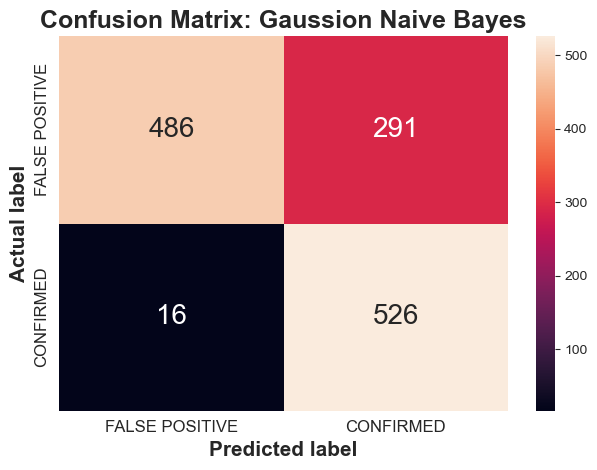


🔎 Optimizing Logistic Regression...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.3s
✅ Logistic Regression best score: 0.8756458386707617 with params OrderedDict({'model__C': 3739.7158904884363, 'model__penalty': 'l2', 'model__solver': 'newton-cg', 'pre__num__scaler': StandardScaler(), 'select__k': 100})

=== Logistic Regression ===
Accuracy: 0.890068233510235
F1: 0.8761742100768574
ROC-AUC: 0.9500040367199039
optimization time: 292.62113904953003

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       777
           1       0.82      0.95      0.88       542

    accuracy                           0.89      1319
   macro avg       0.89      0.90      0.89      1319
weighted avg       0.90      0.89      0.89      1319



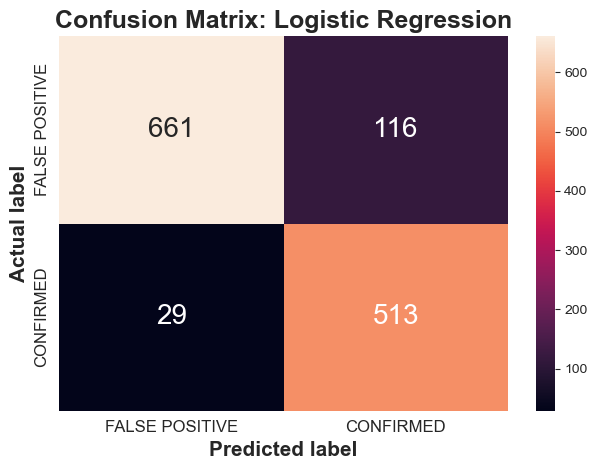


🔎 Optimizing k-Nearest Neighbors Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
✅ k-Nearest Neighbors Classifier best score: 0.8787164271187201 with params OrderedDict({'model__n_neighbors': 10, 'model__p': 1, 'model__weights': 'distance', 'pre__num__scaler': RobustScaler(), 'select__k': 60})

=== k-Nearest Neighbors Classifier ===
Accuracy: 0.8938589840788476
F1: 0.8788927335640139
ROC-AUC: 0.9550190675651932
optimization time: 42.51898169517517

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.91       777
           1       0.83      0.94      0.88       542

    accuracy                           0.89      1319
   macro avg       0.89      0.90      0.89      1319
weighted avg       0.90      0.89      0.89      1319



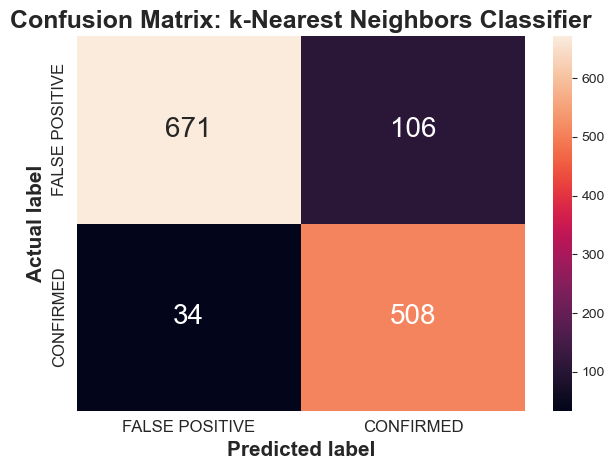


🔎 Optimizing Decision Tree Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.6s
✅ Decision Tree Classifier best score: 0.8703364034219995 with params OrderedDict({'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 6, 'model__min_samples_split': 5, 'pre__num__scaler': StandardScaler(), 'select__k': 100})

=== Decision Tree Classifier ===
Accuracy: 0.8938589840788476
F1: 0.8788927335640139
ROC-AUC: 0.9355976957452972
optimization time: 84.32898306846619

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.91       777
           1       0.83      0.94      0.88       542

    accuracy                           0.89      1319
   macro avg       0.89      0.90      0.89      1319
weighted avg       0.90      0.89      0.89      1319



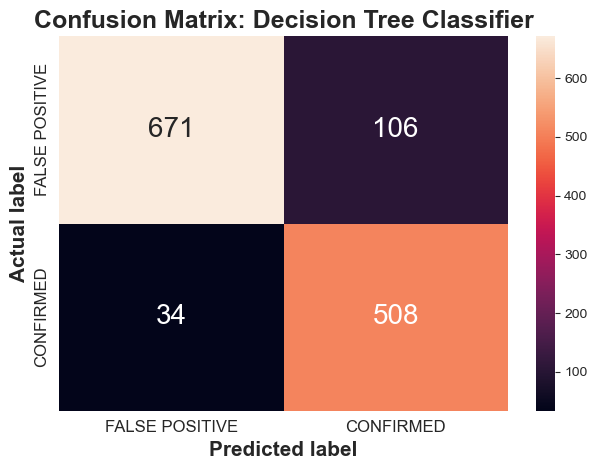


🔎 Optimizing Random Forest Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=  13.4s
✅ Random Forest Classifier best score: 0.904427789826969 with params OrderedDict({'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300, 'pre__num__scaler': StandardScaler(), 'select__k': 100})

=== Random Forest Classifier ===
Accuracy: 0.9287338893100834
F1: 0.9142335766423357
ROC-AUC: 0.9731023854640091
optimization time: 1486.9222793579102

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       777
           1       0.90      0.92      0.91       542

    accuracy                           0.93      1319
   macro avg       0.93      0.93      0.93      1319
weighted avg       0.93      0.93      0.93      1319



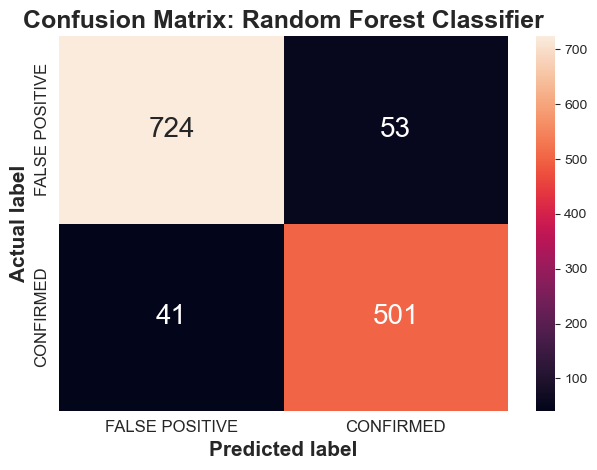


🔎 Optimizing Gradient Boosting Classifier...
      Iter       Train Loss   Remaining Time 
         1           0.8948            3.01m
         2           0.8141            3.48m
         3           0.7442            3.24m
         4           0.6850            3.26m
         5           0.6291            3.23m
         6           0.5812            3.16m
         7           0.5377            3.11m
         8           0.4992            3.14m
         9           0.4658            3.09m
        10           0.4358            3.05m
        20           0.2623            3.01m
        30           0.1881            2.74m
        40           0.1407            2.53m
        50           0.1081            2.38m
        60           0.0846            2.25m
        70           0.0688            2.14m
        80           0.0553            2.03m
        90           0.0451            1.92m
       100           0.0366            1.82m
       200           0.0055           52.97s
       3

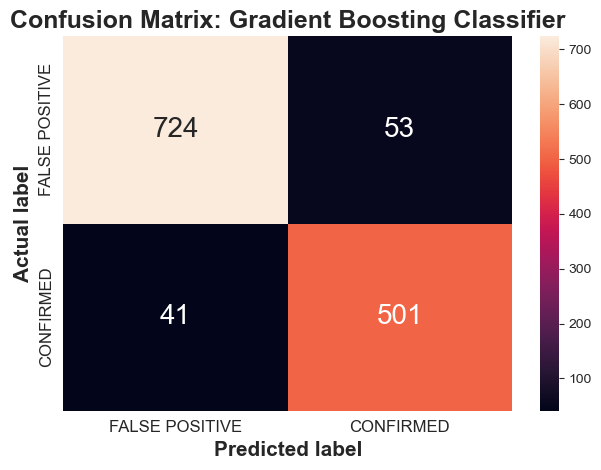


🔎 Optimizing CatBoost Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=   3.9s
✅ CatBoost Classifier best score: 0.9141572602387484 with params OrderedDict({'model__auto_class_weights': 'Balanced', 'model__bagging_temperature': 0.4491972366279183, 'model__border_count': 111, 'model__depth': 8, 'model__iterations': 227, 'model__l2_leaf_reg': 100.0, 'model__learning_rate': 0.15044770877009742, 'model__min_data_in_leaf': 39, 'model__random_strength': 0.0038845219861579064, 'pre__num__scaler': RobustScaler(), 'select__k': 100})

=== CatBoost Classifier ===
Accuracy: 0.9302501895375285
F1: 0.9177101967799642
ROC-AUC: 0.9757511860832894
optimization time: 1244.7701649665833

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       777
           1       0.89      0.95      0.92       542

    accuracy                           0.93      1319
   macro avg       0.93      0.93      0.93      131

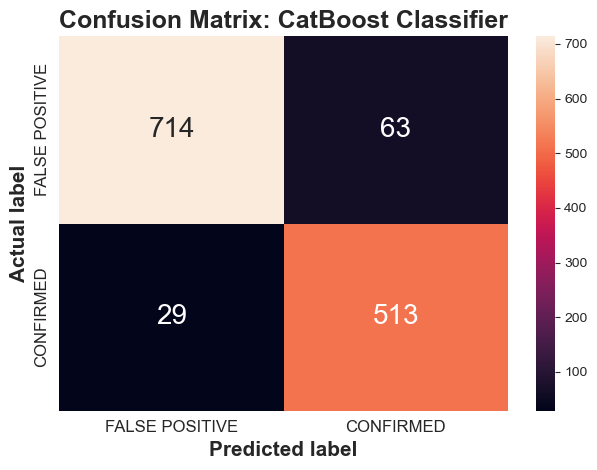


🔎 Optimizing LightGBM Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.2s
✅ LightGBM Classifier best score: 0.9147567886253529 with params OrderedDict({'model__learning_rate': 0.058722132591568346, 'model__max_bin': 50, 'model__max_depth': 13, 'model__min_child_samples': 63, 'model__min_child_weight': 8.0686759632038, 'model__n_estimators': 300, 'model__num_leaves': 8, 'model__reg_alpha': 3.605496326337543e-08, 'model__reg_lambda': 4.45234862603116e-05, 'pre__num__scaler': RobustScaler(), 'select__k': 60})

=== LightGBM Classifier ===
Accuracy: 0.9302501895375285
F1: 0.9175627240143369
ROC-AUC: 0.9763495704455114
optimization time: 215.21282958984375

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       777
           1       0.89      0.94      0.92       542

    accuracy                           0.93      1319
   macro avg       0.93      0.93      0.93      1319
weighted av

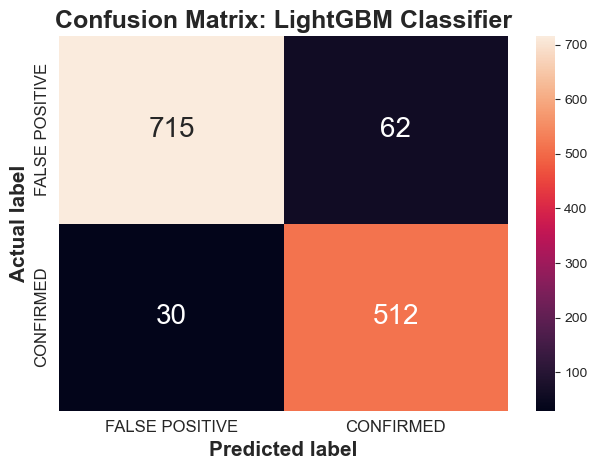


🔎 Optimizing XGBoost Classifier...
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.6s
✅ XGBoost Classifier best score: 0.9140535976734352 with params OrderedDict({'model__colsample_bynode': 0.722590141356303, 'model__gamma': 0.4951997430451711, 'model__learning_rate': 0.14834036582167032, 'model__max_delta_step': 9.370552268841305, 'model__max_depth': 5, 'model__min_child_weight': 6.0785932412132775, 'model__n_estimators': 225, 'model__reg_alpha': 0.006395448486699553, 'model__reg_lambda': 3.790392331733783e-05, 'pre__num__scaler': 'passthrough', 'select__k': 'all'})

=== XGBoost Classifier ===
Accuracy: 0.9370735405610311
F1: 0.9252925292529253
ROC-AUC: 0.9781945888956959
optimization time: 199.79480934143066

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       777
           1       0.90      0.95      0.93       542

    accuracy                           0.94      1319
   macro avg     

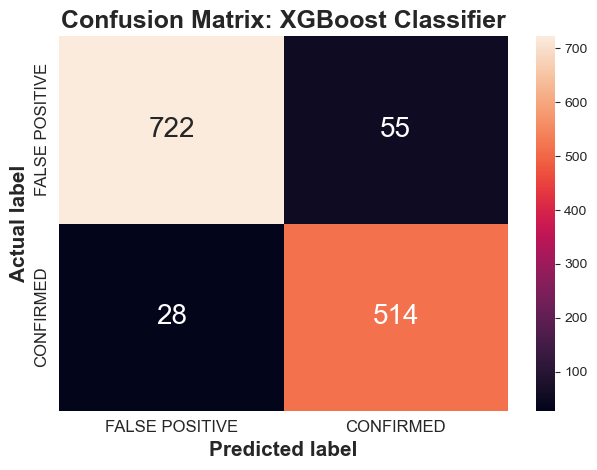


🔎 Optimizing Stacking Classifier...
[Pipeline] ............... (step 1 of 3) Processing pre, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing select, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=  18.3s
✅ Stacking Classifier with estimators: [Gaussion Naive Bayes, k-Nearest Neighbors Classifier, CatBoost Classifier, XGBoost Classifier],
 final estimator: LogisticRegression(class_weight='balanced', max_iter=300, random_state=42) and stack method: ['predict_proba', 'predict_proba', 'predict_proba', 'predict_proba']

=== Stacking Classifier ===
Accuracy: 0.9385898407884761
F1: 0.927484333034915
ROC-AUC: 0.9765751518519046
optimization time: 18.34967041015625

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       777
           1       0.90      0.96      0.93       542

    accuracy                           0.94      1319
   macro avg       0.93      0.94      0.94    

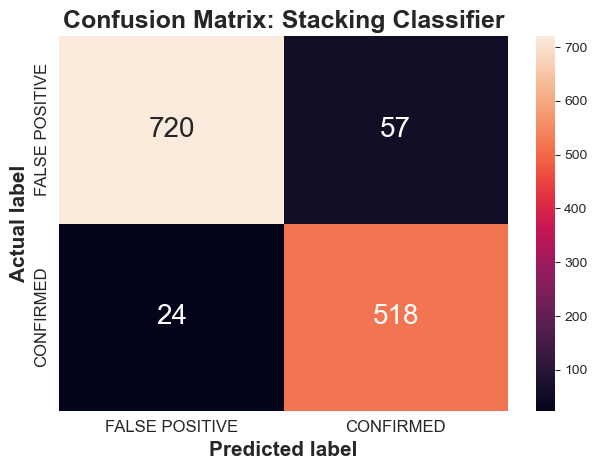

,model,f1,accuracy,roc_auc,optimization time
9,Stacking Classifier,0.927484,0.938590,0.976575,18.349670
8,XGBoost Classifier,0.925293,0.937074,0.978195,199.794809
6,CatBoost Classifier,0.917710,0.930250,0.975751,1244.770165
7,LightGBM Classifier,0.917563,0.930250,0.976350,215.212830
4,Random Forest Classifier,0.914234,0.928734,0.973102,1486.922279
5,Gradient Boosting Classifier,0.914234,0.928734,0.977679,2040.076446
2,k-Nearest Neighbors Classifier,0.878893,0.893859,0.955019,42.518982
3,Decision Tree Classifier,0.878893,0.893859,0.935598,84.328983
1,Logistic Regression,0.876174,0.890068,0.950004,292.621139
0,Gaussion Naive Bayes,0.774099,0.767248,0.807299,48.004792


In [ ]:
import time

fitted = {}
metrics = {}

for name, mdl in models.items():
    print(f"\n🔎 Optimizing {name}...")

    pipe.set_params(model=mdl)
    
    if name == "Stacking Classifier":
        pipe.set_params(model__estimators=[
                                ("Gaussion Naive Bayes", fitted["Gaussion Naive Bayes"]),
                                ("k-Nearest Neighbors Classifier", fitted["k-Nearest Neighbors Classifier"]),
                                ("CatBoost Classifier", fitted["CatBoost Classifier"]),
                                ("XGBoost Classifier", fitted["XGBoost Classifier"]),
                        ],
                        pre="passthrough",
                        select="passthrough",
                )
        opt = pipe
    else:
        opt = BayesSearchCV(
            estimator=pipe,
            search_spaces=param_spaces[name],
            n_iter=60,  # number of parameter settings sampled
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            n_points=4,
            scoring="f1",
            random_state=42,
        )
    
    opt_start=time.time()
    opt.fit(X_train, y_train)
    opt_end=time.time()
    
    if name == "Stacking Classifier":
        fitted[name] = opt
        print(f"✅ {name} with estimators: [Gaussion Naive Bayes, k-Nearest Neighbors Classifier, CatBoost Classifier, XGBoost Classifier],\n final estimator: {opt.named_steps['model'].final_estimator_} and stack method: {opt.named_steps['model'].stack_method_}")
    else:
        fitted[name] = opt.best_estimator_
        print(f"✅ {name} best score: {opt.best_score_} with params {opt.best_params_}")

    y_pred = opt.predict(X_test)
    # Try probability for AUC; fallback if not available
    try:
        y_prob = opt.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        y_prob = None
        try:
            y_dec = opt.decision_function(X_test)
            # In case of multi-class, skip
            auc = roc_auc_score(y_test, y_dec) if y.nunique() == 2 else np.nan
        except Exception:
            auc = np.nan

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    opt_time = opt_end - opt_start

    metrics[name] = {"f1": f1, "accuracy": acc, "roc_auc": auc, "optimization time": opt_time}
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("ROC-AUC:", auc)
    print("optimization time:", opt_time)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    label_map = {0: 'FALSE POSITIVE', 1: 'CONFIRMED'}
    sns.heatmap(cm, annot=True, annot_kws={'fontsize':20}, fmt="d", cbar=True)
    plt.title(f'Confusion Matrix: {name}',  fontsize=18, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=[label_map[0], label_map[1]], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=[label_map[0], label_map[1]], fontsize=12, rotation=90)
    plt.xlabel('Predicted label',  fontsize=15, fontweight='bold')
    plt.ylabel('Actual label', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Summarize metrics
metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index':'model'})
metrics_df.sort_values(by='f1', ascending=False, inplace=True)
display(metrics_df)

In [12]:
joblib.dump(fitted, 'fitted.joblib')
metrics_df.to_csv('metrics.csv', index=False)

### Select best model according to f1 score

- Model Performance Scores

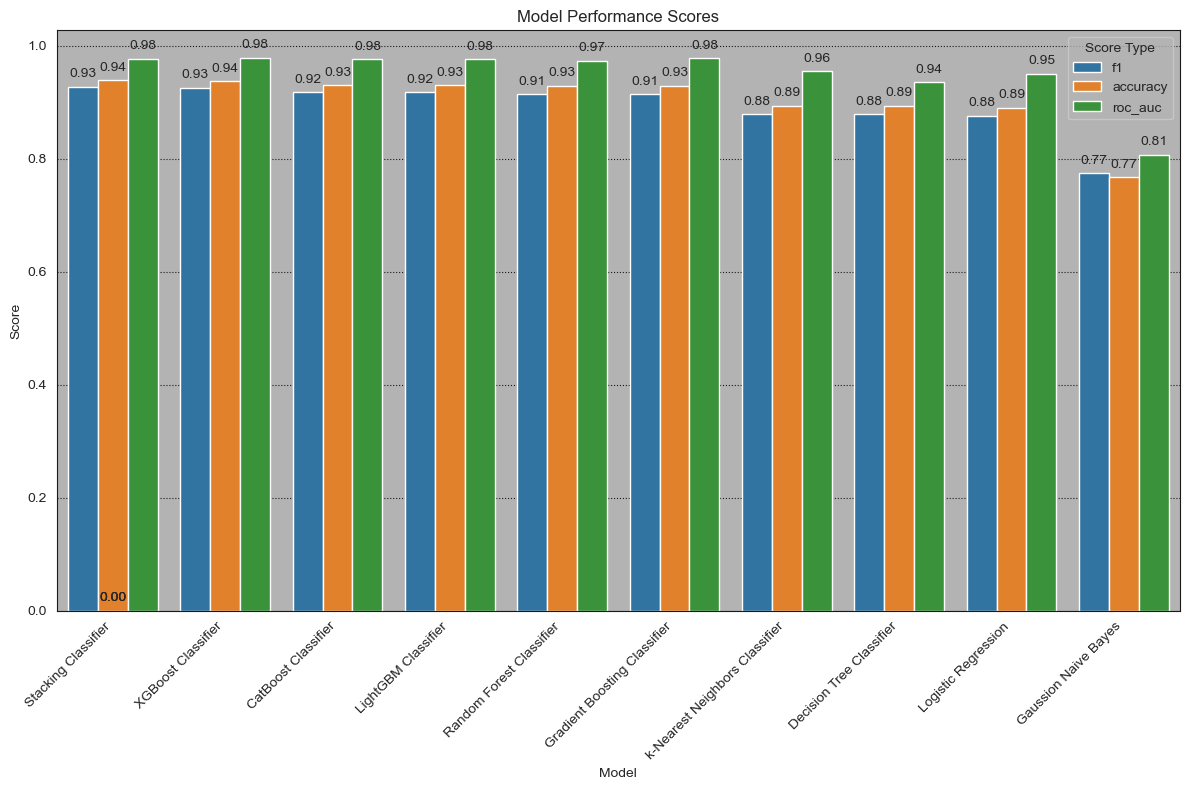

In [ ]:
metrics_df.sort_values(by='f1', ascending=False, inplace=True)

# Reshape the data for grouped bar plot
# This converts f1, accuracy, and roc_auc columns into rows
df_melted = metrics_df.melt(id_vars='model',
                    var_name='score_type',
                    value_name='score_value',
                    value_vars=['f1', 'accuracy', 'roc_auc'])

plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x='model', y='score_value', hue='score_type', data=df_melted)

plt.title('Model Performance Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score Type')
plt.tight_layout()

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

#plt.savefig('model_scores_comparison.png')
plt.show()

- Model Optimization Time

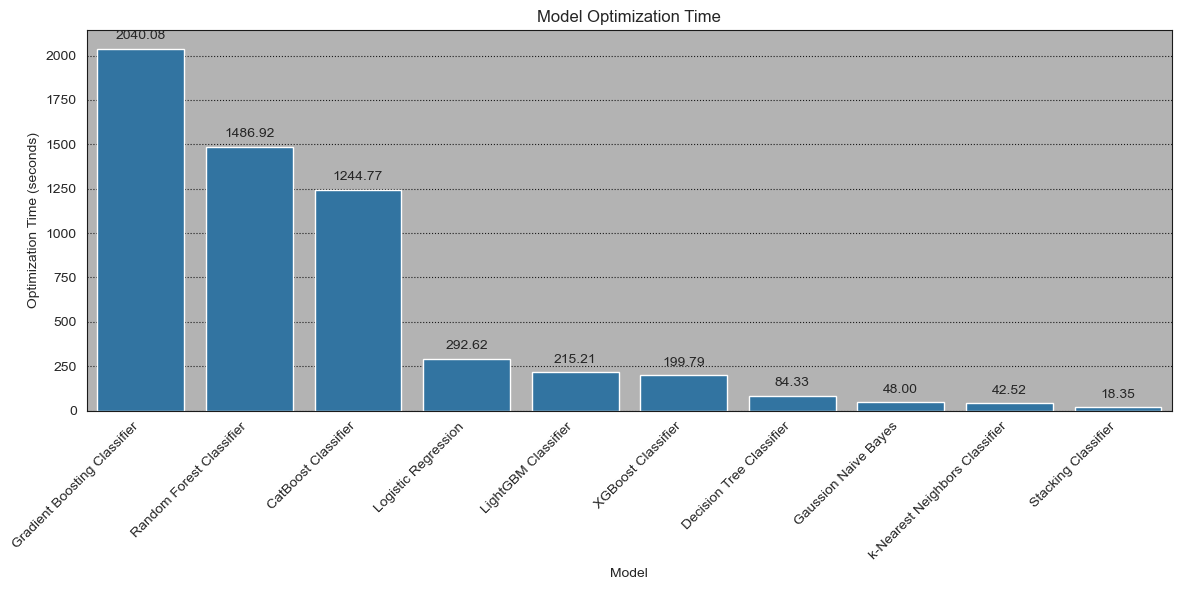

In [ ]:
metrics_df.sort_values(by='optimization time', ascending=False, inplace=True)
plt.figure(figsize=(12, 6))

sorted_df = metrics_df.sort_values('optimization time', ascending=False)

ax2 = sns.barplot(x='model', y='optimization time', data=sorted_df)

plt.title('Model Optimization Time')
plt.xlabel('Model')
plt.ylabel('Optimization Time (seconds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

#plt.savefig('model_optimization_time.png')
plt.show()

- Stacking Classifier has best f1 score and is approximately 94% accurate when classifying between Confirmed and False Positive exoplanets.
- Now we can save this model can it be used to predict the status of the candidate exoplanets.

In [15]:
joblib.dump(fitted["Stacking Classifier"], "model.joblib")

['model.joblib']

<a id='8. Feature Importance'></a>
## **8. Feature Importance** ##

#### CatBoost Classifier

=== SHAP for CatBoostClassifier ===


 98%|===================| 1289/1319 [00:29<00:00]        

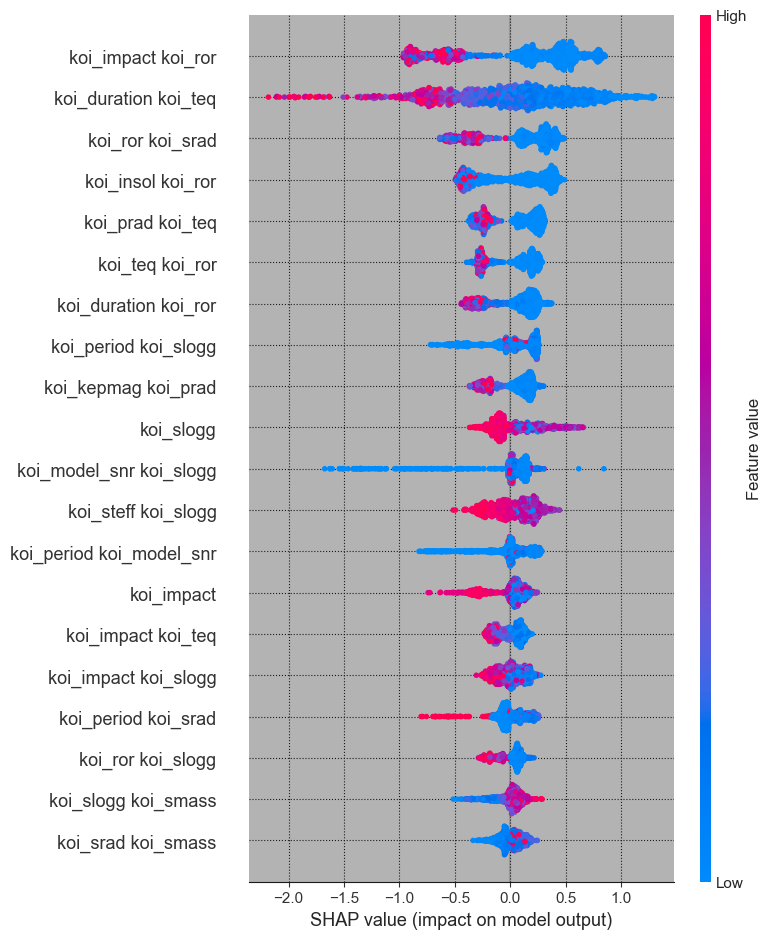

In [ ]:
preprocessor = Pipeline(fitted["CatBoost Classifier"].steps[:-1])
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

pre = fitted["CatBoost Classifier"].named_steps["pre"]
num = pre.named_transformers_["num"]
poly_features = num.named_steps["poly"].get_feature_names_out(X_train.columns)
mask = fitted["CatBoost Classifier"].named_steps["select"].get_support()
selected_features = poly_features[mask]

print("=== SHAP for CatBoostClassifier ===")
cb = fitted["CatBoost Classifier"].named_steps['model']
explainer_cb = shap.Explainer(cb, X_test_transformed)
shap_values_cb = explainer_cb(X_test_transformed)

shap.summary_plot(shap_values_cb, X_test_transformed, feature_names=selected_features)
plt.show()

# NOTE: max_display limits the number of features shown in the plot
# By default it shows top 20 features sorted by mean absolute SHAP value, we can set it to show all features 
# or any number of features as following:
#shap.summary_plot(shap_values_cb, X_test_transformed, max_display=X_test_transformed.shape[1], feature_names=selected_features)

#### XGBoost Classifier

=== SHAP for XGBoostClassifier ===


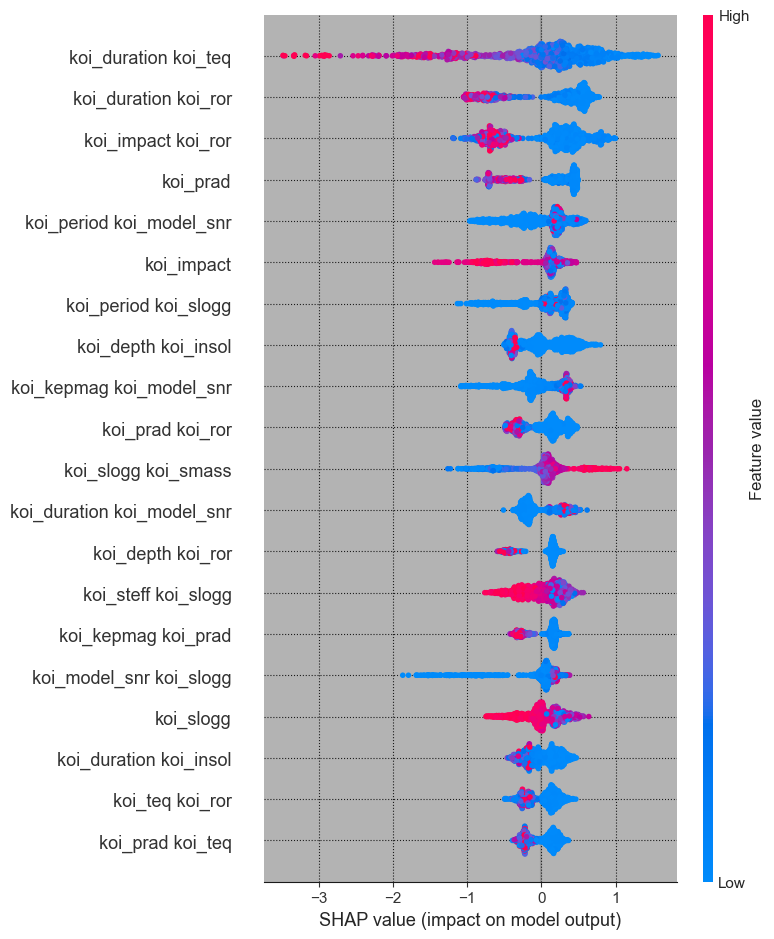

In [ ]:
preprocessor = Pipeline(fitted["XGBoost Classifier"].steps[:-1])
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

pre = fitted["XGBoost Classifier"].named_steps["pre"]
num = pre.named_transformers_["num"]
poly_features = num.named_steps["poly"].get_feature_names_out(X_train.columns)
mask = fitted["XGBoost Classifier"].named_steps["select"].get_support()
selected_features = poly_features[mask]

print("=== SHAP for XGBoostClassifier ===")
xgb = fitted["XGBoost Classifier"].named_steps['model']
explainer_xgb = shap.Explainer(xgb, X_test_transformed)
shap_values_xgb = explainer_xgb(X_test_transformed)

shap.summary_plot(shap_values_xgb, X_test_transformed, feature_names=selected_features)
plt.show()

# NOTE: max_display limits the number of features shown in the plot
# By default it shows top 20 features sorted by mean absolute SHAP value, we can set it to show all features 
# or any number of features as following:
#shap.summary_plot(shap_values_xgb, X_test_transformed, max_display=X_test_transformed.shape[1], feature_names=selected_features)

#### Stacking Classifier

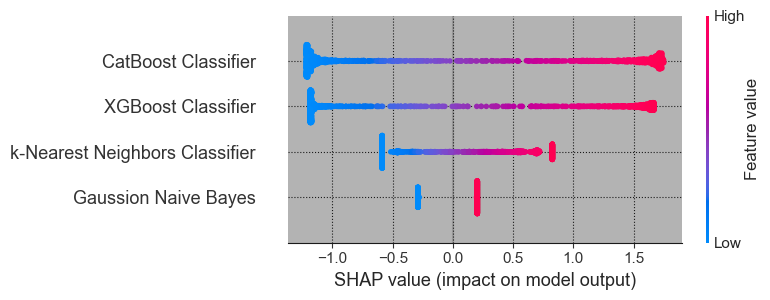

In [20]:
meta = fitted["Stacking Classifier"].named_steps['model'].final_estimator_

explainer_meta = shap.Explainer(meta, fitted["Stacking Classifier"].transform(X_test))
shap_values_meta = explainer_meta(fitted["Stacking Classifier"].transform(X_test))

meta_feature_names = [name for name, _ in fitted["Stacking Classifier"].named_steps['model'].named_estimators_.items()]

shap.summary_plot(shap_values_meta, fitted["Stacking Classifier"].transform(X_test), feature_names=meta_feature_names)
plt.show()

## **Predicting Status of Candidates** ##

In [29]:
candidates_df = df_filtered_encoded[df_filtered_encoded['koi_disposition']==2].drop(columns=['koi_disposition'])

classifier = joblib.load("model.joblib")

y_pred = classifier.predict(candidates_df)
y_prob = classifier.predict_proba(candidates_df)
positive_class_probs = y_prob[:, 1]

candidates_df["pred_class"] = y_pred
candidates_df["probabilities"] = y_prob.tolist()
candidates_df["positive_prob"] = positive_class_probs

unique_values, counts = np.unique(y_pred, return_counts=True)
percentages = counts / counts.sum() * 100

print(candidates_df.head())
print("Counts:", candidates_df['pred_class'].value_counts(), "\n")
candidates_df.to_csv("candidates_predictions.csv", index=False)

for cls, cnt, pct in zip(unique_values, counts, percentages):
    print(f"Class {cls}: {cnt} samples ({pct:.2f}%)")

      koi_kepmag  koi_period  koi_duration  koi_depth  koi_model_snr  \
2715      12.791    3.435916        3.1330       23.2            8.7   
2716      15.750   12.732624        2.2083     6465.7          210.5   
2717      15.754   83.924940        6.7904     7958.7          182.1   
2725      13.682   22.651175        3.6895     2250.0          170.1   
2727      15.808    2.836689        3.0310      166.1           12.1   

      koi_impact  koi_prad  koi_teq  koi_insol   koi_ror  koi_steff  \
2715       0.624      0.55   1272.0     617.61  0.004612     5779.0   
2716       0.811      4.87    432.0       8.22  0.082519     3950.0   
2717       0.658      4.78    226.0       0.62  0.086015     3960.0   
2725       0.925      7.62    855.0     126.57  0.052355     6968.0   
2727       0.330      1.19   1242.0     562.48  0.011852     5831.0   

      koi_slogg  koi_srad  koi_smass  pred_class  \
2715      4.339     1.087      0.941           0   
2716      4.721     0.541      0.563